In [2]:
import pandas as pd
import os

# Set base folder for one year
year = 2015
folder = f"data/raw/{year}"

# Find each file (case-insensitive)
def find_case_insensitive_csv(path, filename):
    for f in os.listdir(path):
        if f.lower() == filename.lower():
            return os.path.join(path, f)
    return None

# Get paths to each required file
acc_path = find_case_insensitive_csv(folder, "accident.csv")
veh_path = find_case_insensitive_csv(folder, "vehicle.csv")
per_path = find_case_insensitive_csv(folder, "person.csv")
dri_path = find_case_insensitive_csv(folder, "drimpair.csv")

# Check if all files are found
print("accident:", acc_path)
print("vehicle:", veh_path)
print("person:", per_path)
print("drimpair:", dri_path)

accident: data/raw/2015/accident.csv
vehicle: data/raw/2015/vehicle.csv
person: data/raw/2015/person.csv
drimpair: data/raw/2015/DrImpair.csv


In [8]:
# Read all 4 files with fallback encoding
acc = pd.read_csv(acc_path, encoding='latin-1', low_memory=False)
veh = pd.read_csv(veh_path, encoding='latin-1', low_memory=False)
per = pd.read_csv(per_path, encoding='latin-1', low_memory=False)
dri = pd.read_csv(dri_path, encoding='latin-1', low_memory=False)

# Add YEAR column to each
acc["YEAR"] = year
veh["YEAR"] = year
per["YEAR"] = year
dri["YEAR"] = year

# Print shapes
print("accident:", acc.shape)
print("vehicle:", veh.shape)
print("person:", per.shape)
print("drimpair:", dri.shape)


accident: (32538, 89)
vehicle: (49478, 188)
person: (81620, 130)
drimpair: (49649, 7)


In [10]:
#Let’s Quickly Inspect the Columns in dri
dri.columns

Index(['STATE', 'STATENAME', 'ST_CASE', 'VEH_NO', 'DRIMPAIR', 'DRIMPAIRNAME',
       'YEAR'],
      dtype='object')

In [11]:
# Since 2015 has no PERSON_ID or DRIVER, we merge on ST_CASE + VEH_NO + YEAR
per_full = per.merge(dri[["ST_CASE", "VEH_NO", "DRIMPAIR", "YEAR"]],
                     on=["ST_CASE", "VEH_NO", "YEAR"],
                     how="left")

print("✅ per_full (person + drimpair):", per_full.shape)


✅ per_full (person + drimpair): (81881, 131)


In [13]:
acc.columns


Index(['STATE', 'STATENAME', 'ST_CASE', 'VE_TOTAL', 'VE_FORMS', 'PVH_INVL',
       'PEDS', 'PERSONS', 'PERMVIT', 'PERNOTMVIT', 'COUNTY', 'CITY', 'DAY',
       'DAYNAME', 'MONTH', 'MONTHNAME', 'YEAR', 'DAY_WEEK', 'DAY_WEEKNAME',
       'HOUR', 'HOURNAME', 'MINUTE', 'MINUTENAME', 'NHS', 'NHSNAME', 'ROUTE',
       'ROUTENAME', 'TWAY_ID', 'TWAY_ID2', 'RUR_URB', 'RUR_URBNAME',
       'FUNC_SYS', 'FUNC_SYSNAME', 'RD_OWNER', 'RD_OWNERNAME', 'MILEPT',
       'MILEPTNAME', 'LATITUDE', 'LATITUDENAME', 'LONGITUD', 'LONGITUDNAME',
       'SP_JUR', 'SP_JURNAME', 'HARM_EV', 'HARM_EVNAME', 'MAN_COLL',
       'MAN_COLLNAME', 'RELJCT1', 'RELJCT1NAME', 'RELJCT2', 'RELJCT2NAME',
       'TYP_INT', 'TYP_INTNAME', 'WRK_ZONE', 'WRK_ZONENAME', 'REL_ROAD',
       'REL_ROADNAME', 'LGT_COND', 'LGT_CONDNAME', 'WEATHER1', 'WEATHER1NAME',
       'WEATHER2', 'WEATHER2NAME', 'WEATHER', 'WEATHERNAME', 'SCH_BUS',
       'SCH_BUSNAME', 'RAIL', 'RAILNAME', 'NOT_HOUR', 'NOT_HOURNAME',
       'NOT_MIN', 'NOT_MINNAME', 'ARR

In [14]:
# Filter to only multi-vehicle crashes
acc_mv = acc[acc["VE_TOTAL"] >= 2]
print("✅ multi-vehicle crashes:", acc_mv.shape)

# Merge accident + vehicle
acc_veh = acc_mv.merge(veh, on=["ST_CASE", "YEAR"], how="inner")
print("✅ acc + veh shape:", acc_veh.shape)

# Merge with person + drimpair
final_df = acc_veh.merge(per_full, on=["ST_CASE", "VEH_NO", "YEAR"], how="inner")
print("✅ final_df shape (full merge):", final_df.shape)


✅ multi-vehicle crashes: (14259, 89)
✅ acc + veh shape: (31199, 275)
✅ final_df shape (full merge): (47160, 403)


In [15]:
# Feature engineering
final_df["IS_NIGHT"] = final_df["LGT_COND"].isin([5, 6, 7]).astype(int)
final_df["ALCOHOL_INVOLVED"] = final_df["DRIMPAIR"] == 1
final_df["MULTI_FATAL"] = final_df["FATALS"] >= 2

# Check new columns
print(final_df[["IS_NIGHT", "ALCOHOL_INVOLVED", "MULTI_FATAL"]].sum())


IS_NIGHT            1532
ALCOHOL_INVOLVED     314
MULTI_FATAL         6998
dtype: int64


In [18]:
!pip3 install pyarrow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.1/32.1 MB 5.3 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip3 install --upgrade pip


In [19]:
import os

os.makedirs("data/processed", exist_ok=True)
final_df.to_parquet("data/processed/fars2015_multivehicle.parquet")

print("✅ Saved to data/processed/fars2015_multivehicle.parquet")


✅ Saved to data/processed/fars2015_multivehicle.parquet


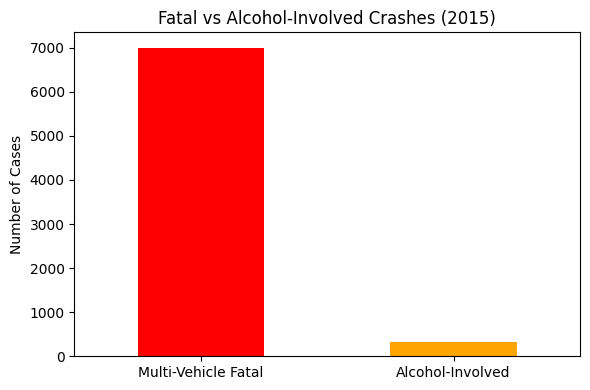

In [20]:
#Let’s visualize multi-fatal vs. alcohol-involved crashes (2015)
import matplotlib.pyplot as plt

# Bar plot comparing fatal vs alcohol crashes
counts = final_df[["MULTI_FATAL", "ALCOHOL_INVOLVED"]].sum()
counts.index = ["Multi-Vehicle Fatal", "Alcohol-Involved"]

counts.plot(kind="bar", color=["red", "orange"], figsize=(6,4))
plt.title("Fatal vs Alcohol-Involved Crashes (2015)")
plt.ylabel("Number of Cases")
plt.xticks(rotation=0)
plt.tight_layout()


✅ Chart saved as data/processed/2015_crash_plot.png


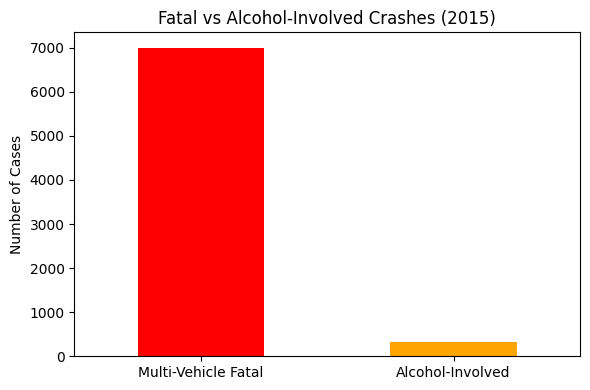

In [21]:
# Save the plot as a PNG file
plt.figure(figsize=(6, 4))
counts.plot(kind="bar", color=["red", "orange"])
plt.title("Fatal vs Alcohol-Involved Crashes (2015)")
plt.ylabel("Number of Cases")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("data/processed/2015_crash_plot.png", dpi=300)

print("✅ Chart saved as data/processed/2015_crash_plot.png")


In [23]:
import pandas as pd
import os

# === Function to find CSV file regardless of case ===
def find_case_insensitive_csv(path, filename):
    for f in os.listdir(path):
        if f.lower() == filename.lower():
            return os.path.join(path, f)
    return None

# === Final container ===
all_years = []

for year in range(2015, 2024):
    print(f"🔄 Processing year: {year}")
    folder = f"data/raw/{year}"

    acc_path = find_case_insensitive_csv(folder, "accident.csv")
    veh_path = find_case_insensitive_csv(folder, "vehicle.csv")
    per_path = find_case_insensitive_csv(folder, "person.csv")
    dri_path = find_case_insensitive_csv(folder, "drimpair.csv")

    if not all([acc_path, veh_path, per_path, dri_path]):
        print(f"❌ Missing one or more files for {year} — skipping")
        continue

    # Load all
    acc = pd.read_csv(acc_path, encoding='latin-1', low_memory=False)
    veh = pd.read_csv(veh_path, encoding='latin-1', low_memory=False)
    per = pd.read_csv(per_path, encoding='latin-1', low_memory=False)
    dri = pd.read_csv(dri_path, encoding='latin-1', low_memory=False)

    for df in [acc, veh, per, dri]:
        df["YEAR"] = year

    # Merge person + drimpair
    if "PERSON_ID" in dri.columns:
        per_full = per.merge(dri, on=["ST_CASE", "VEH_NO", "PERSON_ID", "YEAR"], how="left")
    elif "DRIMPAIR" in dri.columns:
        per_full = per.merge(dri[["ST_CASE", "VEH_NO", "DRIMPAIR", "YEAR"]], 
                             on=["ST_CASE", "VEH_NO", "YEAR"], how="left")
    else:
        print(f"❌ No mergeable key in DRIMPAIR for {year}")
        continue

    # Filter multi-vehicle
    veh_count_col = "TOT_VEH" if "TOT_VEH" in acc.columns else "VE_TOTAL"
    acc_mv = acc[acc[veh_count_col] >= 2]

    # Merge ACC + VEH
    acc_veh = acc_mv.merge(veh, on=["ST_CASE", "YEAR"], how="inner")

    # Merge full
    df = acc_veh.merge(per_full, on=["ST_CASE", "VEH_NO", "YEAR"], how="inner")

    # Features
    df["IS_NIGHT"] = df.get("LGT_COND", pd.Series([None]*len(df))).isin([5, 6, 7]).astype(int)
    df["ALCOHOL_INVOLVED"] = df.get("DRIMPAIR", pd.Series([0]*len(df))).eq(1).astype(int)
    df["MULTI_FATAL"] = df.get("FATALS", pd.Series([0]*len(df))).ge(2).astype(int)

    all_years.append(df)

# Combine all
final_df = pd.concat(all_years, ignore_index=True)
print("✅ Combined shape:", final_df.shape)

# ✅ Fix: Convert object columns to string before saving as Parquet
for col in final_df.select_dtypes(include="object").columns:
    final_df[col] = final_df[col].astype(str)

# Save final files
os.makedirs("data/processed", exist_ok=True)
final_df.to_parquet("data/processed/fars_multiyear.parquet")
final_df.to_csv("data/processed/fars_multiyear.csv", index=False)

print("✅ Saved to data/processed/fars_multiyear.parquet and .csv")


🔄 Processing year: 2015
🔄 Processing year: 2016
🔄 Processing year: 2017
🔄 Processing year: 2018
🔄 Processing year: 2019
🔄 Processing year: 2020
🔄 Processing year: 2021
🔄 Processing year: 2022
🔄 Processing year: 2023
✅ Combined shape: (464241, 465)
✅ Saved to data/processed/fars_multiyear.parquet and .csv


In [ ]:
#📊 Visualization / Charting (Matplotlib/Seaborn)

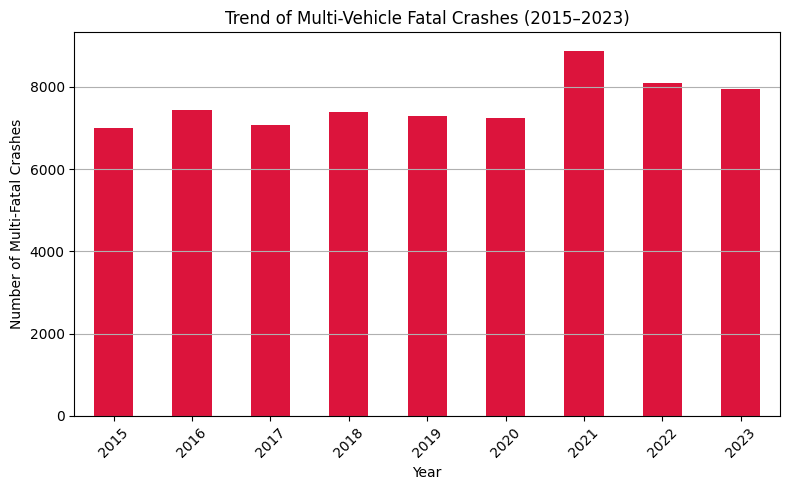

In [24]:
#✅ Step 1A: Trend of Multi-Vehicle Fatal Crashes Across Years
import matplotlib.pyplot as plt

# Count multi-fatal cases per year
fatal_trend = final_df.groupby("YEAR")["MULTI_FATAL"].sum()

# Plot
plt.figure(figsize=(8, 5))
fatal_trend.plot(kind="bar", color="crimson")
plt.title("Trend of Multi-Vehicle Fatal Crashes (2015–2023)")
plt.xlabel("Year")
plt.ylabel("Number of Multi-Fatal Crashes")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.tight_layout()
plt.savefig("data/processed/multifatal_trend_2015_2023.png", dpi=300)
plt.show()


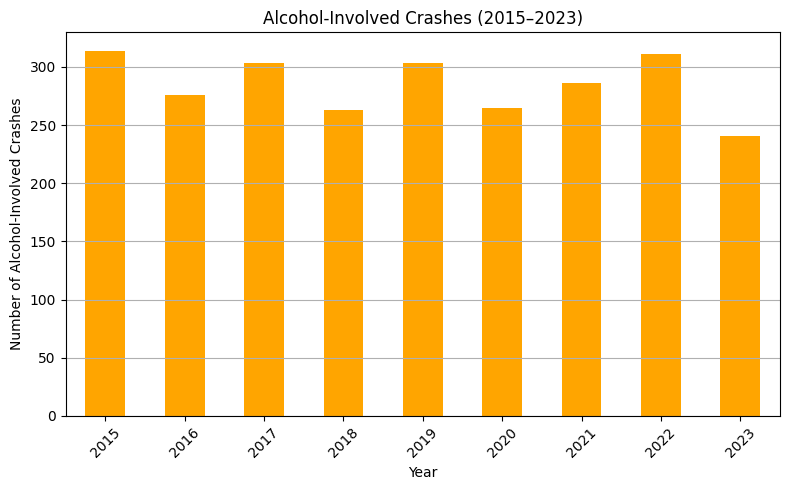

In [25]:
#✅ Step 1B: Alcohol-Involved Crash Trend Across Years
alcohol_trend = final_df.groupby("YEAR")["ALCOHOL_INVOLVED"].sum()

plt.figure(figsize=(8, 5))
alcohol_trend.plot(kind="bar", color="orange")
plt.title("Alcohol-Involved Crashes (2015–2023)")
plt.xlabel("Year")
plt.ylabel("Number of Alcohol-Involved Crashes")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.tight_layout()
plt.savefig("data/processed/alcohol_trend_2015_2023.png", dpi=300)
plt.show()


✅ Chart saved as data/processed/combined_trend_plot.png


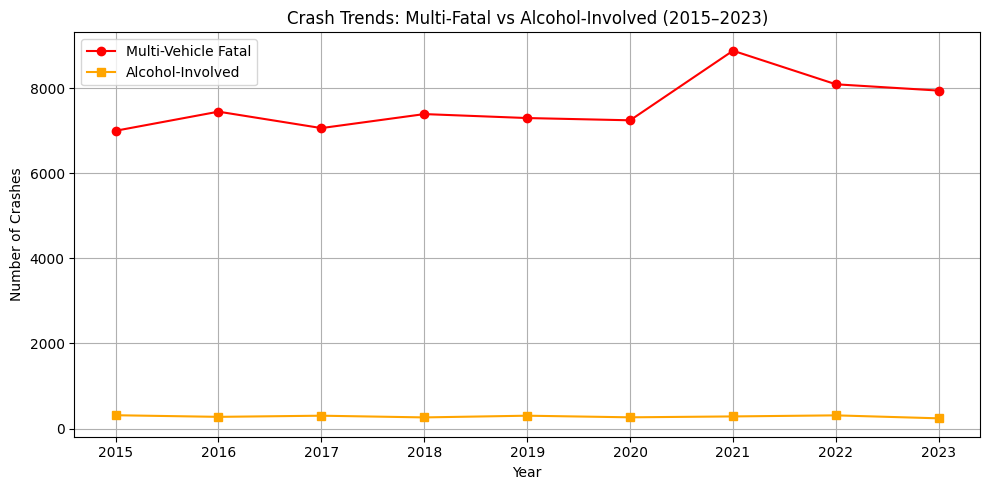

In [26]:
#A. Combined Line Chart: Multi-Fatal vs Alcohol-Involved Trends
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
trend = final_df.groupby("YEAR")[["MULTI_FATAL", "ALCOHOL_INVOLVED"]].sum()
trend["MULTI_FATAL"].plot(label="Multi-Vehicle Fatal", marker='o', color='red')
trend["ALCOHOL_INVOLVED"].plot(label="Alcohol-Involved", marker='s', color='orange')

plt.title("Crash Trends: Multi-Fatal vs Alcohol-Involved (2015–2023)")
plt.xlabel("Year")
plt.ylabel("Number of Crashes")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("data/processed/combined_trend_plot.png", dpi=300)

print("✅ Chart saved as data/processed/combined_trend_plot.png")
plt.show()


✅ Chart saved as data/processed/seaborn_trendlines.png


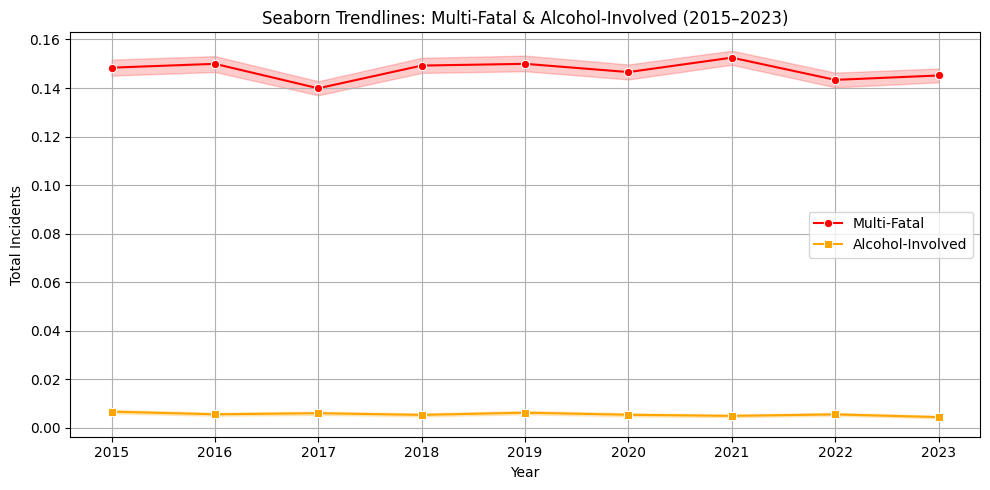

In [27]:
#✅ B. Seaborn Trendlines (Smooth Curves)
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.lineplot(data=final_df, x="YEAR", y="MULTI_FATAL", label="Multi-Fatal", marker='o', color="red")
sns.lineplot(data=final_df, x="YEAR", y="ALCOHOL_INVOLVED", label="Alcohol-Involved", marker='s', color="orange")

plt.title("Seaborn Trendlines: Multi-Fatal & Alcohol-Involved (2015–2023)")
plt.xlabel("Year")
plt.ylabel("Total Incidents")
plt.grid(True)
plt.tight_layout()
plt.savefig("data/processed/seaborn_trendlines.png", dpi=300)

print("✅ Chart saved as data/processed/seaborn_trendlines.png")
plt.show()


✅ Chart saved as data/processed/fatalities_heatmap.png


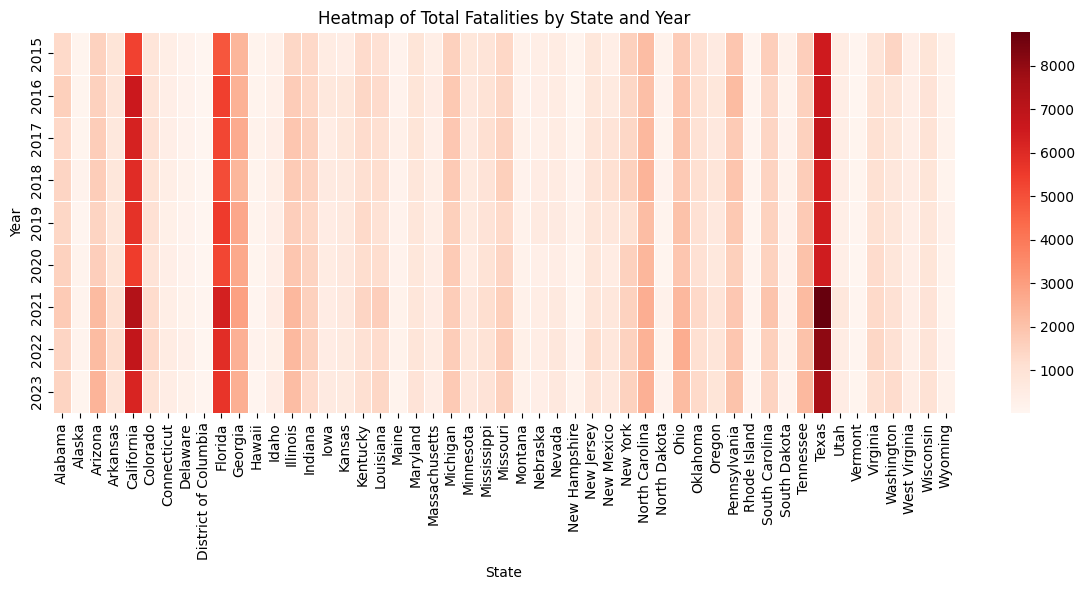

In [28]:
#✅ C. Heatmap: Total Fatalities by State and Year
heat_df = final_df.groupby(["YEAR", "STATENAME"])["FATALS"].sum().unstack().fillna(0)

plt.figure(figsize=(12, 6))
sns.heatmap(heat_df, cmap="Reds", linewidths=0.5)

plt.title("Heatmap of Total Fatalities by State and Year")
plt.xlabel("State")
plt.ylabel("Year")
plt.tight_layout()
plt.savefig("data/processed/fatalities_heatmap.png", dpi=300)

print("✅ Chart saved as data/processed/fatalities_heatmap.png")
plt.show()


In [ ]:
#🔁 Time for Step 2: Advanced Insights
#Let’s go deeper than just charts. We’ll answer:

#🧠 Where are the worst alcohol-nighttime combinations?

#🔎 How many crashes involved alcohol + night + multiple fatalities?



In [29]:
#✅ Step 2A: Alcohol + Night-Time + Multi-Fatal Crash Count
# Combined condition: Alcohol + Night + Multi-Fatal
combined_filter = (final_df["ALCOHOL_INVOLVED"] == 1) & \
                  (final_df["IS_NIGHT"] == 1) & \
                  (final_df["MULTI_FATAL"] == 1)

combo_count = combined_filter.sum()
print("🚨 Total high-risk crashes (Alcohol + Night + Multi-Fatal):", combo_count)


🚨 Total high-risk crashes (Alcohol + Night + Multi-Fatal): 11


✅ Chart saved as data/processed/top_states_highrisk.png


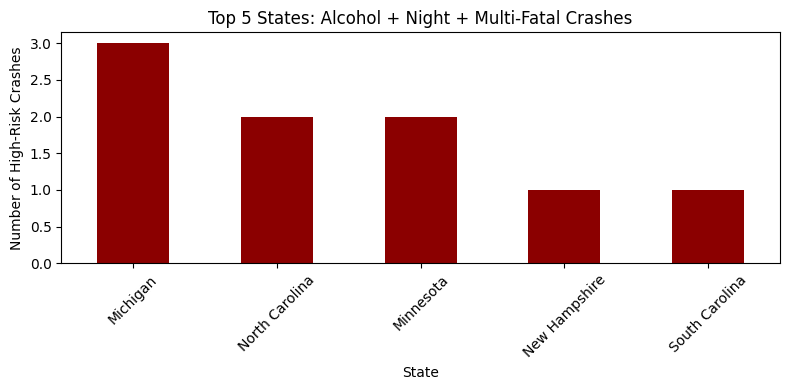

In [30]:
#✅ Step 2B: Top 5 States with Most High-Risk Crashes
high_risk_df = final_df[combined_filter]
top_states_hr = high_risk_df["STATENAME"].value_counts().head(5)

plt.figure(figsize=(8, 4))
top_states_hr.plot(kind="bar", color="darkred")
plt.title("Top 5 States: Alcohol + Night + Multi-Fatal Crashes")
plt.ylabel("Number of High-Risk Crashes")
plt.xlabel("State")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("data/processed/top_states_highrisk.png", dpi=300)

print("✅ Chart saved as data/processed/top_states_highrisk.png")
plt.show()


In [ ]:
#We now have:

#🚨 Deep insights on alcohol + night + multi-fatal crash clusters

#🗺️ Chart of Top 5 deadliest states for high-risk conditions

#📈 Everything stored, visualized, and research-ready

In [ ]:
#✅ Step 3: Split & Save Each Year (CSV + Parquet)

#This is useful for:

#Year-specific dashboards or reports

#Time-series modeling

#Paper appendix or shared datasets

In [33]:
import os

# Create output folders
os.makedirs("data/processed/by_year/csv", exist_ok=True)
os.makedirs("data/processed/by_year/parquet", exist_ok=True)

# Loop through each year and save safely
for yr in sorted(final_df["YEAR"].unique()):
    yearly_df = final_df[final_df["YEAR"] == yr].copy()  # ✅ .copy() removes SettingWithCopyWarning

    csv_path = f"data/processed/by_year/csv/fars_{yr}.csv"
    pq_path = f"data/processed/by_year/parquet/fars_{yr}.parquet"

    # Convert all object columns to string for safe saving
    for col in yearly_df.select_dtypes(include="object").columns:
        yearly_df.loc[:, col] = yearly_df[col].astype(str)

    yearly_df.to_csv(csv_path, index=False)
    yearly_df.to_parquet(pq_path)

    print(f"✅ Saved fars_{yr}.csv and fars_{yr}.parquet")

print("📦 All yearly files saved successfully in: data/processed/by_year/")


✅ Saved fars_2015.csv and fars_2015.parquet
✅ Saved fars_2016.csv and fars_2016.parquet
✅ Saved fars_2017.csv and fars_2017.parquet
✅ Saved fars_2018.csv and fars_2018.parquet
✅ Saved fars_2019.csv and fars_2019.parquet
✅ Saved fars_2020.csv and fars_2020.parquet
✅ Saved fars_2021.csv and fars_2021.parquet
✅ Saved fars_2022.csv and fars_2022.parquet
✅ Saved fars_2023.csv and fars_2023.parquet
📦 All yearly files saved successfully in: data/processed/by_year/


In [ ]:
#here’s Step 5: Generate and save bar chart for each year (2015–2023) comparing:

#Multi-Vehicle Fatal crashes (2+ deaths)

#Alcohol-Involved crashes

In [34]:
import matplotlib.pyplot as plt

# 📁 Create folder to save plots
plot_folder = "data/processed/by_year/plots"
os.makedirs(plot_folder, exist_ok=True)

# 📊 Generate bar chart for each year
for year in range(2015, 2024):
    yearly_df = final_df[final_df["YEAR"] == year]

    # Count how many crashes were multi-fatal and alcohol-involved
    multi_fatal_count = yearly_df["MULTI_FATAL"].sum()
    alcohol_involved_count = yearly_df["ALCOHOL_INVOLVED"].sum()

    # Bar chart data
    counts = [multi_fatal_count, alcohol_involved_count]
    labels = ["Multi-Vehicle Fatal", "Alcohol-Involved"]
    colors = ["red", "orange"]

    # Plot
    plt.figure(figsize=(6, 4))
    plt.bar(labels, counts, color=colors)
    plt.title(f"Fatal vs Alcohol-Involved Crashes ({year})")
    plt.ylabel("Number of Cases")
    plt.xticks(rotation=0)
    plt.tight_layout()

    # Save
    chart_path = f"{plot_folder}/crash_plot_{year}.png"
    plt.savefig(chart_path, dpi=300)
    plt.close()
    print(f"✅ Chart saved: {chart_path}")


✅ Chart saved: data/processed/by_year/plots/crash_plot_2015.png
✅ Chart saved: data/processed/by_year/plots/crash_plot_2016.png
✅ Chart saved: data/processed/by_year/plots/crash_plot_2017.png
✅ Chart saved: data/processed/by_year/plots/crash_plot_2018.png
✅ Chart saved: data/processed/by_year/plots/crash_plot_2019.png
✅ Chart saved: data/processed/by_year/plots/crash_plot_2020.png
✅ Chart saved: data/processed/by_year/plots/crash_plot_2021.png
✅ Chart saved: data/processed/by_year/plots/crash_plot_2022.png
✅ Chart saved: data/processed/by_year/plots/crash_plot_2023.png
